## Environment

This implementation incorporates three new elements:
1. A beeline which the agents keeps track of in order to find the shortest way back after finding the gold
2. the shortest number of turns required to start returning after finding the gold
3. the shortest way back that involves the least number of turns resulting in the best score

Simulation is at the end. A loop is a also setup to test performance

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import namedtuple
from IPython.display import display
from enum import Enum
from pomegranate import *
from pit_wumpus_networks import *
from env_perc_act_kb import *

Agent, Pit, Wumpus, Gold, Breeze, Stench = "A", "P", "W", "G", "B", "S"

In [2]:
class Environment:
    def __init__(self, pitprob, addwumpus=True):
        self.pit_prob = pitprob
        self.allowclimbwithoutgold = True
        self.addwumpus = addwumpus
        self.EnvSize = 4
        self.getIndexes()
        self.getEnv()
        self.startloc = self.setAgent(getloc=True)
        self.pits = []
        self.get_pit_loc()
        
        
    def getMatrix(self, item):
        matrix = []
        try:
            copy = getattr(item, 'copy')
        except AttributeError:
            copy = None
        for i in range(self.EnvSize):
            matrix.append([])
            for j in range(self.EnvSize):
                if copy:
                    matrix[i].append(copy())
                else:
                    matrix[i].append(item)
        return matrix


    def getIndexes(self):
        Indexes = []
        for x in range(self.EnvSize):
            for y in range(self.EnvSize):
                Indexes.append((x, y))
        return Indexes

    def setElement(self, index, value):
        x, y = index
        env[x][y] = value
        # Removes location from Indexes after it is used.
        Indexes.remove(index)

    
    def randomize_pits(self):
        for index in set(Indexes):
            setPit = np.random.binomial(1, self.pit_prob, 1)
            if setPit==1:
                self.setElement(index, Pit)
    
    def get_pit_loc(self):
        pit_loc = np.where(self.environment == "P")
        [self.pits.append((pit_loc[0][i], pit_loc[1][i])) for i in range(len(pit_loc[0]))]
        

    def setWumpus(self):
        index = random.choice(Indexes)
        self.setElement(index, Wumpus)
        self.wumpusloc = index
            
    def setGold(self):
        index = random.choice(Indexes)
        self.setElement(index, Gold)
        self.goldloc = index

    def setAgent(self, getloc=False):
        index = (3, 0)
        if getloc: return index
        else:
            self.setElement(index, Agent)
            self.startloc = index
        

    def refreshGlobals(self):
        global Indexes
        global env
        Indexes = self.getIndexes()
        env = self.getMatrix(0)
        return Indexes, env


    def getEnv(self):
        """ Returns a new Wumpus World environment """
        self.refreshGlobals()
        self.setAgent()
        self.setGold()
        if self.addwumpus: self.setWumpus()
        else: 
            self.wumpusloc = None
            print("👾 Wumpus not spawned 👾")
        self.randomize_pits()
        self.environment = np.array(env)
    
    def printEnv(self, target, agentsteps, spath=None, final_state=False, returnpath=False):
        state = pd.DataFrame(index=["4","3","2","1"], columns=["1","2","3","4"])
        if final_state:
            for step in agentsteps:
                state.iloc[step] = "👣"
        else: state.iloc[agentsteps[-1]] = "👣"
        for pit in self.pits:
            state.iloc[pit] = "🕳️"
        if self.goldloc: state.iloc[self.goldloc] = "💰"
        if self.wumpusloc: state.iloc[self.wumpusloc] = "👾"
        if returnpath:
            try:
                for step in spath:
                    state.iloc[step] = "🦶"
            except: pass
        state = state.fillna(".")        
        print("\nAgent bee line: 👣 |  Shortest route to {}: 🦶\nGold: 💰 | Wumpus: 👾 | Pits: 🕳️ | Unattended: .\n".format(target))

        return state

## Percepts

Naive agent has no use for these, unless agent is on gold, wumpus, pit, or exit, which are implemented in the main loop

In [4]:
percept_mapping = {Pit: "B", Wumpus: "S"}
items= {1: "Agent", 2: "Pit", 3: "Wumpus", 4: "Gold", 5:"Breeze", 6:"Stench"}

class Percepts(Environment):
    def __init__(self, pitprob, addwumpus):
        super().__init__(pitprob, addwumpus)       
        self.wumpuscry = False
        
        self.percepts = self.getMatrix(set()) # empty sets containing all state information of each room
        
        
        Indexes = self.getIndexes()
        for x, y in Indexes:
            if self.environment[x, y] and self.environment[x, y] != "A":
                self.addPercept((x, y), self.environment[x, y])

            if (x + 1, y) in Indexes:
                num = percept_mapping.get(self.environment[x + 1, y], None)
                if num:
                    self.addPercept((x, y), num)

            if (x - 1, y) in Indexes:
                num = percept_mapping.get(self.environment[x - 1, y], None)
                if num:
                    self.addPercept((x, y), num)

            if (x, y + 1) in Indexes:
                num = percept_mapping.get(self.environment[x, y + 1], None)
                if num:
                    self.addPercept((x, y), num)

            if (x, y - 1) in Indexes:
                num = percept_mapping.get(self.environment[x, y - 1], None)
                if num:
                    self.addPercept((x, y), num)
                
        self.percept_hist = [list(self.getPercept(self.startloc[0], self.startloc[1])),]

    def addPercept(self, index, num):
        x, y = index
        self.percepts[x][y].add(num)

    def getPercepts(self):
        return self.percepts
        
    def getPercept(self, x, y):
        return (self.percepts[x][y])

## Knowledge base

This knowledge base currently contains information about the environment that the agent doesn't have, however, the agent only uses this information when it is perceived. Future version will put information in it's proper place.

In [5]:
class KB(Percepts):
    def __init__(self, pitprob, addwumpus):
        super().__init__(pitprob, addwumpus)

        self.loc_path = [(self.startloc),]
        self.curr_dir = [1,] # 0, 1, 2, 3 - up, right, down, left
        self.action = ["Forward","Tright","Tleft","Shoot", "Grab", "Climb"]
        self.haveGold = False
        self.dead = False
        self.haveArrow = True
        self.arrow_path = []
        self.score = 0
        self.moves = 0
        
    def get_arrow_path(self):
        if self.haveArrow:
            if self.curr_dir[-1] == 0: # Up
                for i in range(self.loc_path[-1][0]):
                    self.arrow_path.append((self.loc_path[-1][0] - i - 1, self.loc_path[-1][1]))
            if self.curr_dir[-1] == 1: # Right
                for i in range(len(env) - (self.loc_path[-1][1]) - 1):
                    self.arrow_path.append((self.loc_path[-1][0], self.loc_path[-1][1] + i + 1))
            if self.curr_dir[-1] == 2: # Down
                for i in range(len(env) - self.loc_path[-1][0] - 1):
                    self.arrow_path.append((i, self.loc_path[-1][1]))
            if self.curr_dir[-1] == 3: # Left
                for i in range(self.loc_path[-1][1]):
                    self.arrow_path.append((self.loc_path[-1][0], i))
    
    def get_shortest_route(self, source, target, intermediate):
        '''
        Note: this includes turns.
        '''
        G = nx.Graph()
        # Adding nodes
        if intermediate:
            nodes = []
            [nodes.append(i) for i in self.loc_path]
            nodes.append(target)
            
        else:
            nodes = list(set(self.loc_path))
        
        for a, (i, j) in enumerate(nodes):
            G.add_node(a, coordinate=(i,j))

        # mapping nodes to coordinates
        dictionary = {}
        for e in range(len(G.nodes)):
            x = G.nodes[e]['coordinate']
            dictionary[x] = e

        # adding edges
        edges = []

        # Connecting nodes for edges
        for i in range(10**(self.EnvSize-1)):
            a = random.choice(nodes)
            b = random.choice(nodes)
            if a[0] == b[0] and (np.absolute(a[1] - b[1]) == 1):        
                edges.append((a, b))
            elif a[1] == b[1] and (np.absolute(a[0] - b[0])== 1):
                edges.append((a, b))
        edges = set(edges)

        # generating edges
        edge_list = []
        for i, j in edges:
            x, y = dictionary.get(i), dictionary.get(j)
            edge_list.append((x,y))

        for i in edge_list:
            G.add_edge(*i)

        # remapping nodes to coordinates
        all_paths = nx.all_simple_paths(G, source=dictionary.get(source), target=dictionary.get(target))
        paths = []
        for i in all_paths:
            paths.append(i)

        dictionaries = []
        [dictionaries.append(dict()) for i in range(len(paths))]
        
        for i in range(len(dictionaries)):
            for j in paths[i]:
                x = G.nodes[j]['coordinate']
                dictionaries[i][j] = x

        paths_back = []
        [paths_back.append(list()) for i in range(len(paths))]

        for i in range(len(dictionaries)):
            for j in paths[i]:    
                x, y = dictionaries[i].get(j)
                paths_back[i].append((x,y))

        lengths = []
        for i in range(len(dictionaries)):
            lengths.append(len(paths_back[i]))
            for j in range(len(paths_back[i])):
                try:
                    if (paths_back[i][j+1][0] == paths_back[i][j][0]) and (paths_back[i][j+1][1] != paths_back[i][j][1]):
                        if (paths_back[i][j+2][0] != paths_back[i][j+1][0]):
                            lengths[i] += 1
                    elif (paths_back[i][j+1][1] == paths_back[i][j][1]) and (paths_back[i][j+1][0] != paths_back[i][j][0]):
                        if (paths_back[i][j+2][1] != paths_back[i][j+1][1]):
                            lengths[i] += 1
                    else: pass
                except: pass

        # Original paths without turns        
        lengths2 = []
        for i in range(len(dictionaries)):
            lengths2.append(len(paths_back[i]))
#         shortest path back considering turns
        try: shortest_path_back = paths_back[lengths.index(min(lengths))]
        except: shortest_path_back = [self.loc_path[-1]]
        # number of turns
        try: no_turns = lengths[lengths.index(min(lengths))] - lengths2[lengths.index(min(lengths))]
        except: no_turns = 0
        # execute path
        try: [self.loc_path.append(shortest_path_back[i+1]) for i in range(len(shortest_path_back)-1)]
        except: pass
        return shortest_path_back, no_turns


## Actuators

In [6]:
class Actuators(KB):
    def __init__(self, pitprob, addwumpus, verbose):
        super().__init__(pitprob, addwumpus)
        self.verbose = verbose
        
    def forward(self, direction):
        if direction == 0: # facing up
            self.loc_path.append((self.loc_path[-1][0]-1, self.loc_path[-1][1]))
        elif direction == 1: # facing right
            self.loc_path.append((self.loc_path[-1][0], self.loc_path[-1][1]+1))
        elif direction == 2: # facing down
            self.loc_path.append((self.loc_path[-1][0] + 1, self.loc_path[-1][1]))
        else: # facing left
            self.loc_path.append((self.loc_path[-1][0], self.loc_path[-1][1]-1))
        self.score -= 1
        if self.verbose: 
            print("Current score: {}".format(self.score))
        try:
            self.percept_hist.append(list(self.getPercept(self.loc_path[-1][0], self.loc_path[-1][1])))
        except:
            pass
        
    def bump(self):
        if len(self.loc_path) > 1:
            self.loc_path.pop(-1)
        if self.verbose: 
            print("Agent attempts to move, bupms into a wall.")
            print("Current score: {}".format(self.score))
    
    def turnright(self, direction):
        if direction < 3: self.curr_dir.append(self.curr_dir[-1]+1)
        else: self.curr_dir.append(0)
        self.score -= 1
        if self.verbose: 
            print("Agent turns right.")
            print("Current score: {}".format(self.score))
        
    def turnleft(self, direction):
        if direction > 0: self.curr_dir.append(self.curr_dir[-1]-1)                 
        else: self.curr_dir.append(3)
        self.score -= 1
        if self.verbose: 
            print("Agent turns left.")
            print("Current score: {}".format(self.score))
        
    def shoot(self, probagent):
        arrow_path = self.arrow_path
        if self.verbose: print("🏹🏹 Agent fires arrow 🏹🏹")
        if not probagent:
            if self.wumpusloc and (self.wumpusloc in arrow_path):
                self.wumpuscry = True
                self.wumpusloc = None
                if self.verbose: print("Wumpus killed!")
            else: 
                if self.verbose:
                    print("Arrow misses its mark")
        else:
            self.wumpuscry = True
            self.wumpusloc = None
            if self.verbose: print("Wumpus killed!")
        self.haveArrow = False
        self.score -= 10
    
    
    def grab(self, probagent):
        if self.verbose: print("Agent attempts to grab something.")
        if not probagent:
            if (self.goldloc == self.loc_path[-1]) and not self.haveGold:
                self.haveGold = True
                if self.verbose: print("💰💰Agent picks up the gold💰💰")
                self.goldloc = None
            else: 
                if self.verbose: 
                    print("Agent grabs nothing.")
                    print("Current score: {}".format(self.score))
        else: 
            self.haveGold = True
            if self.verbose: print("💰💰Agent picks up the gold💰💰")
            self.goldloc = None
        
        self.score -= 1
        
        
    def climb(self, allowclimbwithoutgold=True):
        if not allowclimbwithoutgold:
            if self.havegold:
                print("Agent climbs out with the gold")
                self.score += (1000 - 1)
            else:
                if self.verbose:
                    print("Agent attempts to climb out but does not have the gold.")

        else:
            if self.haveGold:
                self.score += 1000
                if self.verbose: print("🎉🎉Agent climbs out of the cave with the gold.🎉🎉")
            else: 
                if self.verbose: print("Agent climbs out without the gold.")
        self.score -= 1
        if self.verbose: print("Final score: ", self.score)
       
    
    def make_shortest_turn(self, pathback): # note the use of a numpy array means indexes for rows are inversed

        current = pathback[0]
        try: nextone = pathback[1]
        except: nextone = current

        if nextone != current:
            if current[0] != nextone[0] and current[1] == nextone[1]:
                if current[0] > nextone[0]: # if shortest way back starts above agent

                    if self.curr_dir[-1] == 1: self.turnleft(direction=1)
                    elif self.curr_dir[-1] == 3: self.turnright(direction=3)
                    elif self.curr_dir[-1] == 2:# if agent facing down, turn right twice  (or left, it doesn't matter)
                        self.turnright(direction=2), self.turnright(direction=3)
                    else: pass

                elif current[0] < nextone[0]: # if shortest way back starts below agent

                    if self.curr_dir[-1] == 1: self.turnright(direction=1)
                    elif self.curr_dir[-1] == 3: self.turnleft(direction=3)
                    elif self.curr_dir[-1] == 0: # if agent facing up, turn right twice (or left, it doesn't matter)
                        self.turnright(direction=0), self.turnright(direction=1)
                    else: pass
                else: pass

            elif current[0] == nextone[0] and current[1] != nextone[1]:

                if current[1] > nextone[1]: # if shortest way back starts left of agent

                    if self.curr_dir[-1] == 0: self.turnleft(direction=0)
                    elif self.curr_dir[-1] == 2: self.turnright(direction=2)
                    elif self.curr_dir[-1] == 1: # if agent facing right, turn right twice (or left, it doesn't matter)
                        self.turnright(direction=1), self.turnright(direction=2) 
                    else: pass

                elif current[1] < nextone[1]: # if shortest way back starts right of agent

                    if self.curr_dir[-1] == 0: self.turnright(direction=0)
                    elif self.curr_dir[-1] == 2: self.turnleft(direction=2)
                    elif self.curr_dir[-1] == 3: # if agent facing left, turn right twice (or left, it doesn't matter)
                        self.turnright(direction=3), self.turnright(direction=0)
                    else: pass
                else: pass
            else: pass

In [3]:
from pit_wumpus_networks import *
from wumpusworld import *

In [4]:
class ProbAgent(Actuators):
    def __init__(self, pitprob, addwumpus, verbose):
        super().__init__(pitprob, addwumpus, verbose)
        self.pitprob = pitprob
        self.beliefs = self.populate_beliefs()
        self.confirmedpits = []
        self.confirmedwumpus = None
        self.get_beliefs()
        self.getPercepts()
    
    def populate_beliefs(self):
        beliefs = np.array(self.getMatrix(dict()))
        items = ["Ok", "Known", "Frontier", "Stench", "Wumpus", "Breeze", "Pit"]
        for item in items:
            for i in range(self.EnvSize):
                for j in range(self.EnvSize):
                    (beliefs[i, j])["{}".format(item)] = 0
        return beliefs
    
    def get_beliefs(self):

        # updating confirmed pits/no pits, ok/not ok locations, non-frontier locations,          
        Indexes = self.getIndexes()
        if len(self.confirmedpits) > 0: #and any(loc in adjacents for loc in self.confirmedpits):
            for loc in self.confirmedpits:
                (self.beliefs[loc])["Pit"] = 1            
        for loc in self.loc_path:
            self.beliefs[loc]["Ok"] = 1
            self.beliefs[loc]["Frontier"] = 0
            self.beliefs[loc]["Pit"] = 0
        
        # Updating frontier, confirmed stench and breeze
        for loc in self.loc_path:
            i, j = loc[0], loc[1]
            
            percept = self.getPercept(i, j)
            if "S" in percept: self.beliefs[(i,j)]["Stench"] = 1
            if "B" in percept: self.beliefs[(i,j)]["Breeze"] = 1
                    
            adjacents = [(i+1,j),(i-1,j),(i,j+1),(i,j-1)]        
            for a in adjacents:
                if (a not in self.loc_path) and (a in Indexes) and (self.beliefs[a]["Pit"] != 1):
                    (self.beliefs[a])["Frontier"] = 1
            
                
                    
    def get_wumpus_proba(self, confirmedpits, stenchsensed, wumpustarget, wumpusalive):
        model = bake_wumpus_network(confirmedpits=confirmedpits, wumpusalive=wumpusalive, wumpusspawned=self.addwumpus)
        query, wumpusprobs = dict(), []
        for i in range(len(stenchsensed)):
            query["Stench{}{}".format(stenchsensed[i][0][0], stenchsensed[i][0][1])] = "{}".format(stenchsensed[i][1])
        dist = model.predict_proba([query])[0][0].parameters[0]

        for loc in (wumpustarget):
            prob = [(loc[0], loc[1]), dist["{},{}".format(loc[0], loc[1])]]
            wumpusprobs.append(prob)
        return wumpusprobs
    
    def get_pit_proba(self, wumpusloc, breezelocs, pitlocs, targetpit):
        if wumpusloc: model = bake_pit_network(wumpusloc=wumpusloc[0], pitprob=self.pitprob)
        else: model = bake_pit_network(wumpusloc=None, pitprob=self.pitprob)
#         pits = self.getIndexes()
        pits = [(0,0),(0,1),(0,2),(0,3), (1,0),(1,1),(1,2),(1,3), 
                (2,0),(2,1),(2,2),(2,3), (3,0),(3,1),(3,2),(3,3)]
        
        target, pitprobs, query = [], [], {}
        
        target.append([pits.index(i) for i in targetpit])
        for i in range(30):
            try:
                query["Breeze{}{}".format((breezelocs[i][0][0]), 
                                               (breezelocs[i][0][1]))] = "{}".format(breezelocs[i][1])
                query["Pit{}{}".format((pitlocs[i][0][0]), 
                                            (pitlocs[i][0][1]))] = "{}".format(pitlocs[i][1])
            except: pass
        for i, j in enumerate(target[0]):
            pitprobs.append([((targetpit[i][0]), (targetpit[i][1])), model.predict_proba([query])[0][j].parameters[0].get("1")])
        return pitprobs

    def confirmed_pit_wumpus(self,pitprob, wumpusprob):
        # update beliefs if wumpus location is confirmed
        
        if (not self.wumpuscry) and (not self.confirmedwumpus):
            for loc in wumpusprob:
                if loc[1]==1: 
                    self.beliefs[loc[0]]["Wumpus"] = 1
                    self.confirmedwumpus=1
                else: pass
        # update beliefs if pit location is confirmed
        for loc in pitprob:
            if loc[1]==1: 
                self.beliefs[loc[0]]["Pit"] = 1
                self.confirmedpits.append(loc[0])

    def shoot_wumpus(self, wumpus):
        candidates, distances = [], []
        # get possible points form which wumpus may be shot at
        for loc in set(self.loc_path):
            try:
                if loc[0] == self.confirmedwumpus[0][0] or loc[1] == self.confirmedwumpus[0][1]:
                    candidates.append(loc)
            except:pass
        # get closes of above points to current agent location
        for loc in candidates:
            euclidist = ((self.loc_path[-1][0] - loc[0])**2 + (self.loc_path[-1][1] - loc[1])**2)**0.5
            distances.append(euclidist)
        elected = candidates[np.argmin(distances)]
        if self.verbose:
            print("Agent confirms existence of wumpus. Agent is currently at {} and moved to {} to shoot the wumpus."
                  .format(self.loc_path[-1], elected))
        path = self.get_shortest_route(source=self.loc_path[-1], target=elected, intermediate=True) # get shortest path
        self.make_shortest_turn(pathback=path[0])                                # turn to shortest path
        self.make_shortest_turn(pathback=[self.loc_path[-1], wumpus[0]]) # turn to face wumpus
        if self.verbose:
            display(self.printEnv(agentsteps=self.loc_path, spath=path[0], final_state=True, returnpath=True, target=elected))
            print("Agent facing:", self.curr_dir[-1], "\n [0: Up | 1: Right | 2: Down | 3: Left]")
        self.shoot(probagent=True)
        
        # updating sense map and beliefs to remove wumpus and stench and mark wumpus loc as Ok
        Indexes = self.getIndexes()
        for loc in Indexes:
            self.beliefs[loc]["Wumpus"] = 0
            self.beliefs[loc]["Stench"] = 0
            self.percepts[loc[0]][loc[1]].discard("W")
            self.percepts[loc[0]][loc[1]].discard("S")
        self.beliefs[self.confirmedwumpus[0]]["Ok"] = 1
                
        
    def decide_on_action(self, risk):
        if self.verbose: 
            display(self.printEnv(agentsteps=self.loc_path, spath=None, final_state=False, returnpath=False, target=None))
            display("Percepts: \n", pd.DataFrame(self.percepts))

        targets, pits, breezes, stenches, candidates, elected = [], [], [], [], [], []
        self.get_beliefs()
        
        Indexes = self.getIndexes()
        for loc in Indexes:
            if self.beliefs[loc]["Frontier"] == 1 and loc not in self.confirmedpits: targets.append(loc)
            if self.beliefs[loc]["Pit"] == 1: pits.append([loc, 1])
        for loc in set(self.loc_path):
            if self.beliefs[loc]["Breeze"] == 1: breezes.append([loc, 1])
            else: breezes.append([loc, 0])
            if self.beliefs[loc]["Stench"] == 1: stenches.append([loc, 1])
            else: stenches.append([loc, 0])
            if self.beliefs[loc]["Pit"] == 0: pits.append([loc, 0])
        if self.verbose: 
            print("Targets:", targets)
            print("Breeze", breezes)
            print("Stenches", stenches)
            print("Pits", pits)
        
        pitproba = self.get_pit_proba(wumpusloc=self.confirmedwumpus, breezelocs = breezes, pitlocs = pits, targetpit = targets)
        wumpusproba = self.get_wumpus_proba(confirmedpits=self.confirmedpits, stenchsensed = stenches, wumpustarget = targets, wumpusalive=(False == self.wumpuscry))
        
        if self.verbose: display("Wumpus probs:",wumpusproba)

        if not self.wumpuscry: 
            for loc in wumpusproba:
                if loc[1] == 1: 
                    self.confirmedwumpus = [loc[0]]
                    self.shoot_wumpus(self.confirmedwumpus)
                    self.wumpuscry=True
                    if self.verbose: display(np.array(self.percepts))
            # Update probability if wumpus killed:
            wumpusproba = self.get_wumpus_proba(confirmedpits=self.confirmedpits, stenchsensed = stenches, wumpustarget = targets, wumpusalive=(False == self.wumpuscry))
            if self.verbose: display("New wumpus probs:",wumpusproba)
        
        self.confirmed_pit_wumpus(pitprob=pitproba, wumpusprob=wumpusproba)
        if self.verbose:
            display("Pit probs:", pitproba)
            display(self.beliefs)
            
            print("Targets:", targets)
            print("Breeze", breezes)
            print("Stenches", stenches)
            print("Pits", pits)

        # if gold is found, head for exit and escape
        
        
        for i, j in zip(pitproba, wumpusproba):
            try:
                x = np.argmax([i[1], j[1]])
                if x == 1: candidates.append(j)
                elif x == 0: candidates.append(i)
            except: candidates.append(pitproba[i], wumpusproba[j]) 
        if self.verbose: 
            print("Candidates: ", candidates)
        
        [elected.append(candidates[i][1]) for i in range(len(candidates))]
        if self.verbose: print("Probabilities of candiadte pits: ",elected)
        try: elected = candidates[np.argmin(elected)]
        except:
            return "no next move"
        if self.verbose: print("Chosen location: ", elected)

        
        # move to another location if nothing in this location and if it is safe to move
        # else, quit        
        if elected[1] < risk: # move
            path = self.get_shortest_route(source=self.loc_path[-1], target=elected[0], intermediate=True)
            self.make_shortest_turn(pathback=path[0])
            self.score -= (len(path[0]) + path[1] - 1) # excludes current room
            if self.verbose:
                print("Agent moves to: ", self.loc_path[-1], "Score: ", self.score)
                print("Target location: ", elected[0],"Agent path: ", self.loc_path)
            
            if elected[0] in self.pits:
                if self.verbose: display(self.printEnv(agentsteps=self.loc_path, spath=path[0], final_state=True, returnpath=True, target=self.loc_path[-1]))
                self.score -= 1000
                print("🕳️ Agent falls into a pit and dies. 🕳️")
                return "no next move"

            elif (not self.wumpuscry) and elected[0] == self.wumpusloc:
                if self.verbose: display(self.printEnv(agentsteps=self.loc_path, spath=path[0], final_state=True, returnpath=True, target=self.wumpusloc))
                self.score -= 1000
                print("👾 Agent falls victim to the wumpus. 👾")
                return "no next move"
            elif elected[0] == self.goldloc:
                self.loc_path.append(self.goldloc)
                self.grab(probagent=1)
                path = self.get_shortest_route(source=self.loc_path[-1], target=self.loc_path[0], intermediate=False)
                self.make_shortest_turn(pathback=path[0])
                self.score -= (len(path[0]) + path[1] - 1) # excludes current room
                self.climb()
                display(self.printEnv(agentsteps=self.loc_path, spath=path[0], final_state=True, returnpath=True, target=self.loc_path[0]))
                return "no next move"
            else:             
                display(self.printEnv(agentsteps=self.loc_path, spath=path[0], final_state=True, returnpath=True, target=elected[0]))
                return "move"

        else: # quit
            if self.verbose: display("Too risky! Quitting...")
            path = self.get_shortest_route(source=self.loc_path[-1], target=self.loc_path[0], intermediate=False)
            self.make_shortest_turn(pathback=path[0])
            self.score -= (len(path[0]) + path[1] - 1) # excludes current room
            display(self.printEnv(agentsteps=self.loc_path, spath=path[0], final_state=True, returnpath=True, target=self.loc_path[0]))
            self.climb()

            return "no next move"
        

            

# Simulation

Initialize/refresh environment:

**1. Pitprob** - set pit probability between 0 (for no pits) and 1 (all other room have pits) for testing functionality

**2. Addwumpus** - add wumpus (True/False) for testing functionality

**3. Verbose** - 
    True: shows every detail of environment and probabilistic thinking
    False: Shows final score

In [36]:
def simulate(verbose=False, addwumpus=False, pitprob=0.2, risk=0.33): # risk  34.3, 34.4 is optimal
    PA = ProbAgent(addwumpus=addwumpus, verbose=verbose, pitprob=pitprob)
    next_move = "move"
    while next_move == "move":
        move = PA.decide_on_action(risk=risk)
        next_move = move
    return PA.score

In [37]:
simulate(verbose=0, addwumpus=1, pitprob=0.2, risk=0.33)

NameError: name 'path' is not defined

#### Optimizing probability of surivival

In [32]:
risks = np.arange(30, 38, 0.5)
means = []
for j in risks:
#     print(j)
    scores = []
    for i in range(500):
        score = simulate(verbose=False, addwumpus=True, pitprob=0.2, risk=j)
        scores.append(score)
    means.append(np.mean(scores))
print("Optimal risk at which agent should quit is when probability of death is greater than ", risks[np.argmax(means)]/100)

Optimal risk at which agent should quit is when probability of death is greater than  0.33


<AxesSubplot:title={'center':'Score vs Risk Tradeoff'}>

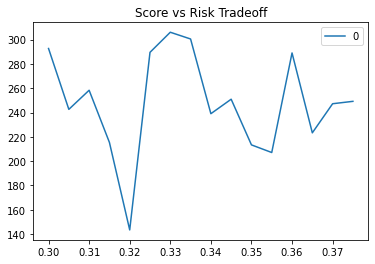

In [30]:
pd.DataFrame(data=(means), index=risks/100).plot(title="Score vs Risk Tradeoff")